In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (10631, 0.2526)  |  explosion: (10106, 0.2402)  |  noise: (21343, 0.5072)  
Val ds:
earthquake: (242, 0.0371)  |  explosion: (3125, 0.4788)  |  noise: (3160, 0.4841)  
Test ds:
earthquake: (184, 0.0423)  |  explosion: (2062, 0.4739)  |  noise: (2105, 0.4838)  


In [3]:
model_type = "DENSE_grow"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()



Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 59.068033933639526 seconds. Total datapoints fitted: 42080.
Average time per datapoint: 0.0014037080307423842


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 11.747495889663696 seconds. Total datapoints fitted: 6527.
Average time per datapoint: 0.001799830839537873


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 31.425004243850708 seconds. Total datapoints fitted: 4351.
Average time per datapoint: 0.007222478566731949


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validation set, timeAug: [--------------------------------------->] 100 %

Stage one loading test set, timeAug: [--------------------------------------->] 100 %

Fitting scaler progress: [------------------->] 100 %

Stage two load

# Final 3N model:

Trying to create result file
Made result file:  results_DENSE_grow_noiseNotNoise_timeAug_standard_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3.csv
[   {'model_type': 'DENSE_grow'},
    {   'activation': 'relu',
        'batch_size': 64,
        'dropout_T_bn_F': False,
        'dropout_rate': 0.1,
        'epochs': 50,
        'growth_sequence': [1],
        'l1_r': 0,
        'l2_r': 0,
        'learning_rate': 0.001,
        'num_layers': 1,
        'optimizer': 'rmsprop',
        'output_layer_activation': 'sigmoid',
        'units': 200,
        'use_layerwise_dropout_batchnorm': False}]
Saving file. 3 rows.
results_DENSE_grow_noiseNotNoise_timeAug_standard_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (In

- val_f1: 0.8551
Epoch 24/50
657/657 [==============================] - 20s 30ms/step - loss: 0.1834 - binary_accuracy: 0.9327 - precision: 0.9671 - recall: 0.8940 - val_loss: 0.9573 - val_binary_accuracy: 0.8550 - val_precision: 0.9226 - val_recall: 0.7837
- val_f1: 0.8487
Epoch 25/50
657/657 [==============================] - 19s 29ms/step - loss: 0.2118 - binary_accuracy: 0.9365 - precision: 0.9697 - recall: 0.8990 - val_loss: 0.9361 - val_binary_accuracy: 0.8589 - val_precision: 0.9060 - val_recall: 0.8093
- val_f1: 0.8569
Epoch 26/50
657/657 [==============================] - 20s 31ms/step - loss: 0.2169 - binary_accuracy: 0.9402 - precision: 0.9691 - recall: 0.9073 - val_loss: 0.9686 - val_binary_accuracy: 0.8606 - val_precision: 0.8809 - val_recall: 0.8436
- val_f1: 0.8623
Epoch 27/50
657/657 [==============================] - 20s 30ms/step - loss: 0.1666 - binary_accuracy: 0.9416 - precision: 0.9691 - recall: 0.9109 - val_loss: 1.0351 - val_binary_accuracy: 0.8597 - val_precisi

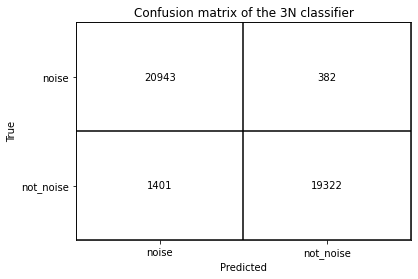

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[20943,   382],
       [ 1401, 19322]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.94      0.98      0.96     21325
   not_noise       0.98      0.93      0.96     20723

    accuracy                           0.96     42048
   macro avg       0.96      0.96      0.96     42048
weighted avg       0.96      0.96      0.96     42048

Unsaved val eval:
2847 279 585 2753
['noise', 'not_noise']
3N


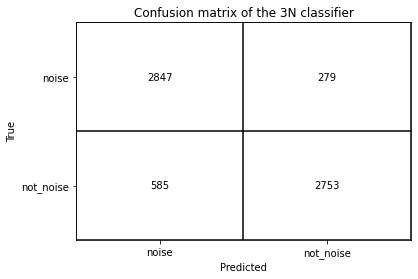

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2847,  279],
       [ 585, 2753]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.83      0.91      0.87      3126
   not_noise       0.91      0.82      0.86      3338

    accuracy                           0.87      6464
   macro avg       0.87      0.87      0.87      6464
weighted avg       0.87      0.87      0.87      6464

Unsaved test eval:
1889 176 358 1865
['noise', 'not_noise']
3N


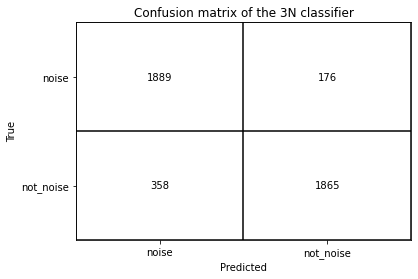

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1889,  176],
       [ 358, 1865]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.84      0.91      0.88      2065
   not_noise       0.91      0.84      0.87      2223

    accuracy                           0.88      4288
   macro avg       0.88      0.88      0.88      4288
weighted avg       0.88      0.88      0.88      4288



In [4]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True
beta = 1


params = {
        "batch_size" : 64,
        "epochs" : 50,
        "learning_rate" : 0.001,
        "optimizer" : "rmsprop",
        "num_layers" : 1,
        "units" : 200,
        "dropout_T_bn_F" : False,
        "use_layerwise_dropout_batchnorm" : False,
        "growth_sequence" : [1],
        "dropout_rate" : 0.1,
        "l2_r" : 0,
        "l1_r" : 0,
        "activation" : "relu",
        "output_layer_activation" : "sigmoid"
    }

workers = 32
max_queue_size = 20

finalModel = TrainSingleModelRam(noiseAug, helper, loadData,
                                 model_type, num_channels, use_tensorboard,
                                 use_liveplots, use_custom_callback, 
                                 use_early_stopping, use_reduced_lr, ramLoader,
                                 log_data = log_data,
                                 start_from_scratch = start_from_scratch, 
                                 beta = beta)
model = finalModel.run(x_train, y_train, x_val, y_val, x_test, y_test, workers, max_queue_size, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, index = None, **params)

2848 278 591 2747
['noise', 'not_noise']
3N


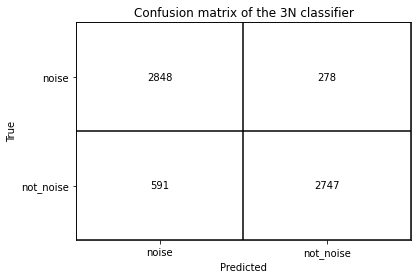

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2848,  278],
       [ 591, 2747]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.83      0.91      0.87      3126
   not_noise       0.91      0.82      0.86      3338

    accuracy                           0.87      6464
   macro avg       0.87      0.87      0.87      6464
weighted avg       0.87      0.87      0.87      6464



(<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2848,  278],
        [ 591, 2747]], dtype=int32)>,
 '              precision    recall  f1-score   support\n\n       noise       0.83      0.91      0.87      3126\n   not_noise       0.91      0.82      0.86      3338\n\n    accuracy                           0.87      6464\n   macro avg       0.87      0.87      0.87      6464\nweighted avg       0.87      0.87      0.87      6464\n',
 0.86556311881188119,
 0.90809899999999999,
 0.82294800000000001,
 0.863429)

In [8]:
helper.evaluate_generator(model, x_val, y_val, params["batch_size"], loadData.label_dict, num_channels, noiseAug, scaler_name, 2, plot_conf_matrix = True, beta = beta)

In [9]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/DENSE'
model_name = 'dense_3N_final'
model_path = f'{save_dir}/{model_name}'

#model.save(model_path)
#model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: /media/tord/T7/Thesis_ssd/SavedModels/DENSE/dense_3N_final/assets


In [13]:
predictions = helper.predict_RamGenerator(model, x_val, y_val, params["batch_size"], False, noiseAug, loadData.label_dict, 3)
rounded_predictions = np.rint(predictions)

In [15]:
def get_false_negative_indexes(rounded_predictions, y_test):
    false_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 0:
            false_negative_indexes.append(i)
    return false_negative_indexes

def get_false_positive_indexes(rounded_predictions, y_test):
    false_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 1:
            false_positive_indexes.append(i)
    return false_positive_indexes

def get_true_positive_indexes(rouneded_predictions, y_test):
    true_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 1:
            true_positive_indexes.append(i)
    return true_positive_indexes

def get_true_negative_indexes(rouneded_predictions, y_test):
    true_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 0:
            true_negative_indexes.append(i)
    return true_negative_indexes

In [31]:
false_negatives_indexes = get_false_negative_indexes(rounded_predictions, y_val)
false_positives_indexes = get_false_positive_indexes(rounded_predictions, y_val)
true_negative_indexes = get_true_negative_indexes(rounded_predictions, y_val)
true_positive_indexes = get_true_positive_indexes(rounded_predictions, y_val)


# True Positives

In [22]:
import pprint
i = 0
pp = pprint.PrettyPrinter(indent = 4)

Predicted label: [ 1.], Correct: [1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


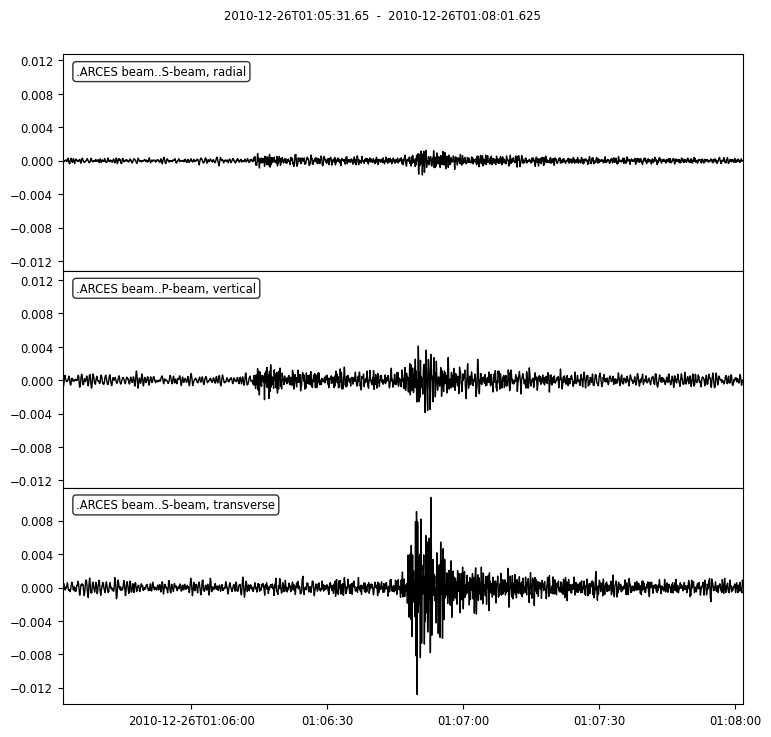

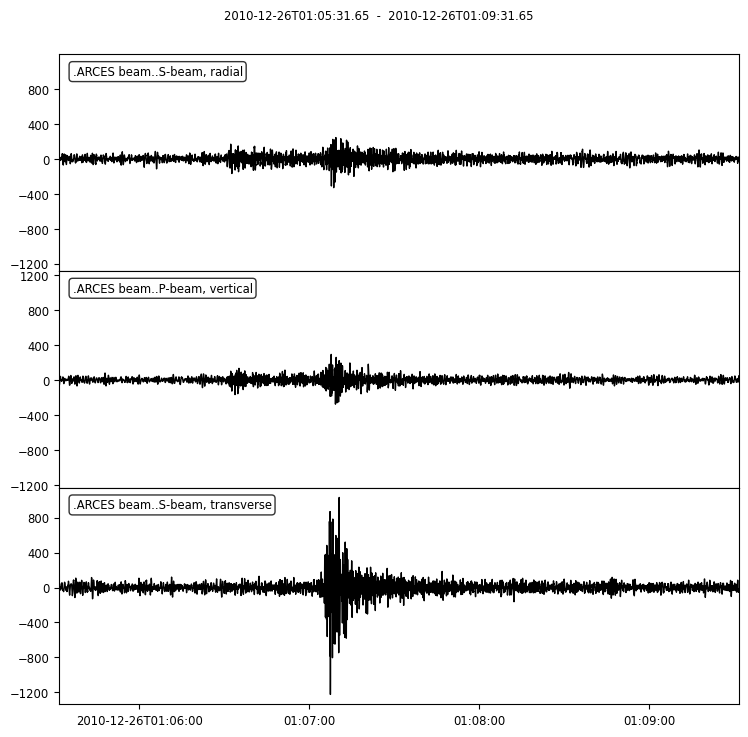

{   'analyst_pick_time': None,
    'az_to_arces': 45.83391562946081,
    'baz_to_arces': 230.7950592255849,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/e6357dc2-5f72-43df-8337-1936a78ac742',
                        'text': 'FULLY AUTOMATIC LOCATION'},
                    {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/557b367e-2f1d-4d2a-8181-be59e1c2d251',
                        'text': 'SWEDEN'}],
    'dist_to_arces': 289.5310787054862,
    'est_arrivaltime_arces': '2010-12-26 01:06:31.643000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.005180790976590856,
    'magnitude_sqrtdist_ratio': 0.0881543332167301,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 1.5,
                          'mag_errors': {'uncertainty': 0.1},
                          'magnitude_type': 'ML

In [118]:
# Plotting false negative
index = true_positive_indexes[i]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
i += 1

# False Positives

In [32]:
j = 0

Predicted label: [ 0.56414706], Correct: [0]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


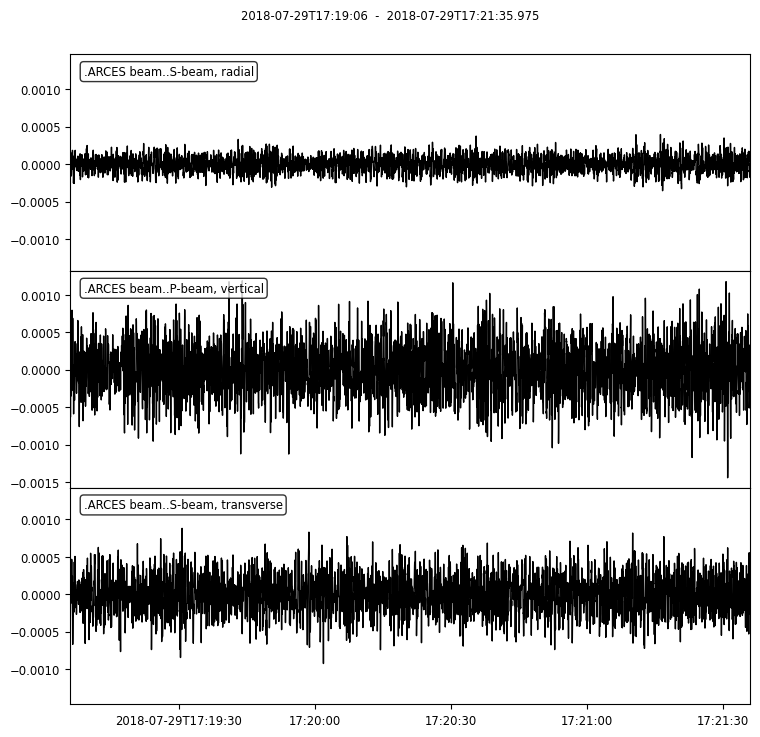

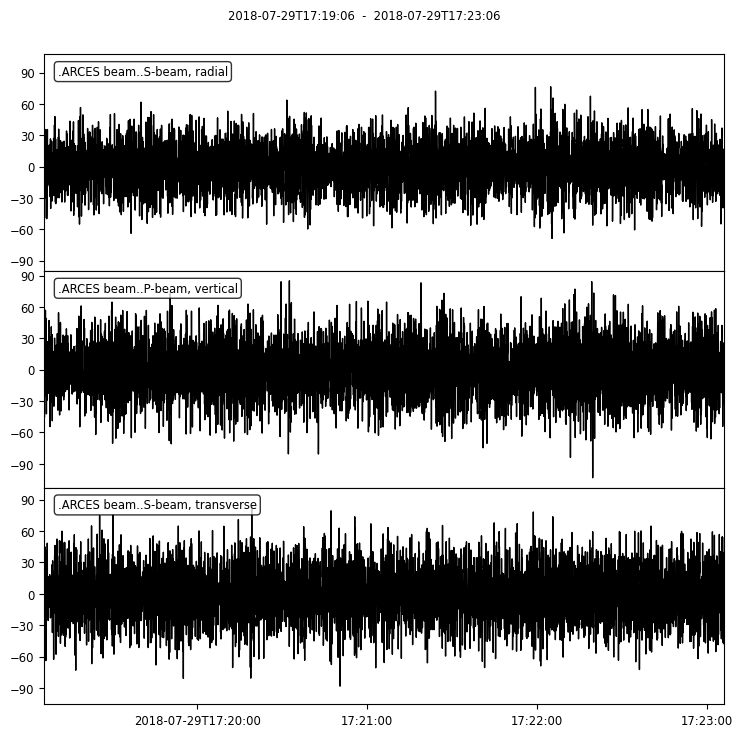

{   'analyst_pick_time': None,
    'baz_to_arces': 2.138814635647847,
    'est_arrivaltime_arces': '2018-07-29 17:20:06',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2018-07-29T17:19:06.000000Z',
                       'station': 'ARCES beam'}}


In [98]:
# Plotting false negative
index = false_positives_indexes[j]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
j += 1

# True Negatives

In [34]:
k = 0

Predicted label: [ 0.00884661], Correct: [0]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


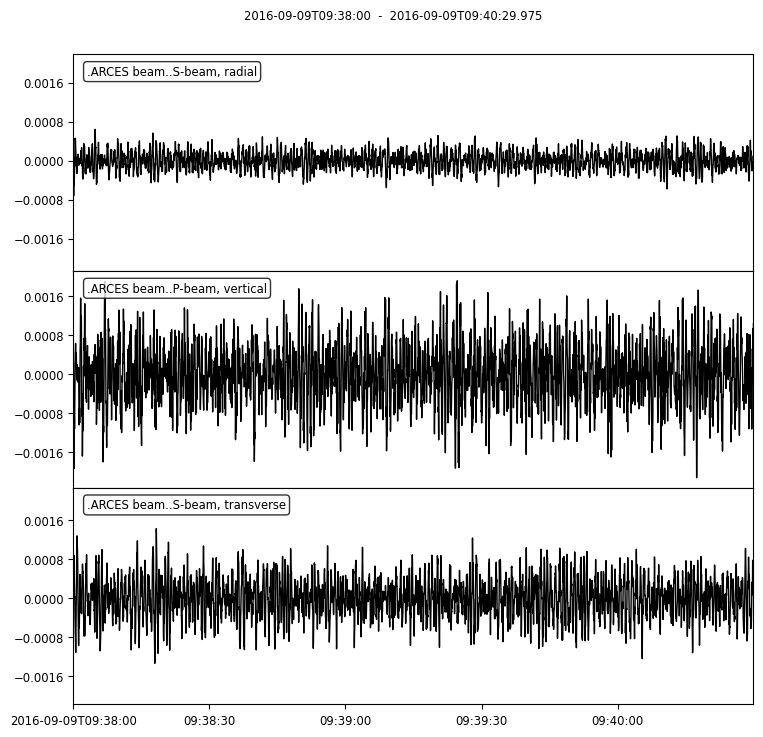

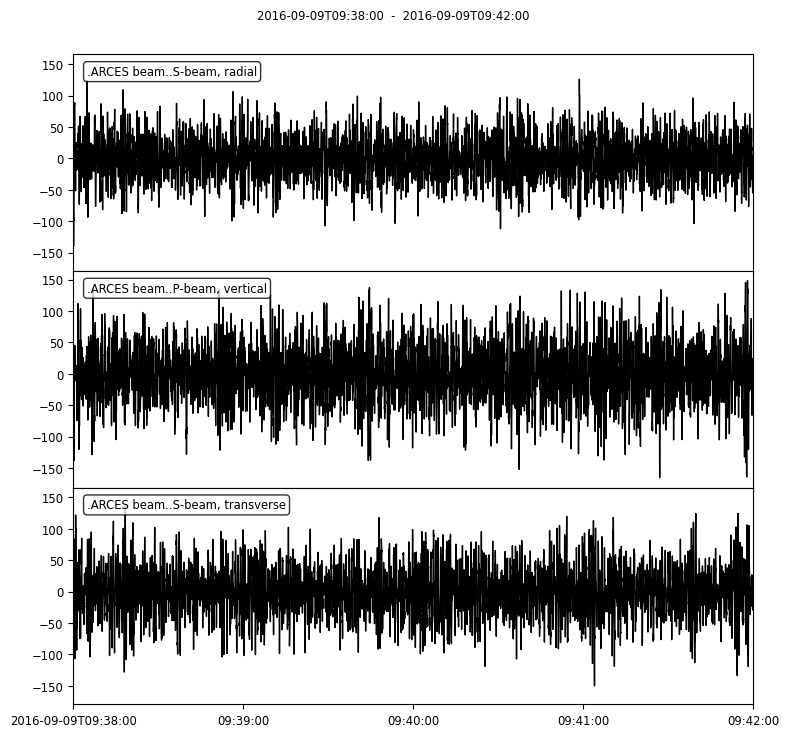

{   'analyst_pick_time': None,
    'baz_to_arces': 0.7981901854746318,
    'est_arrivaltime_arces': '2016-09-09 09:39:00',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2016-09-09T09:38:00.000000Z',
                       'station': 'ARCES beam'}}


In [99]:
# Plotting false negative
index = true_negative_indexes[k]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
k += 1

# False Negatives

In [38]:
m = 0

Predicted label: [ 0.35894954], Correct: [1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


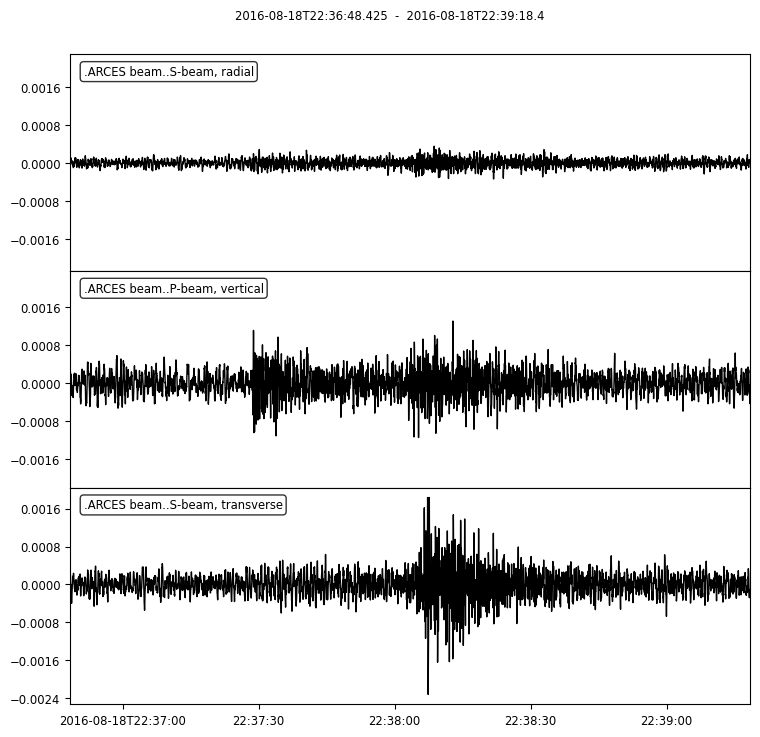

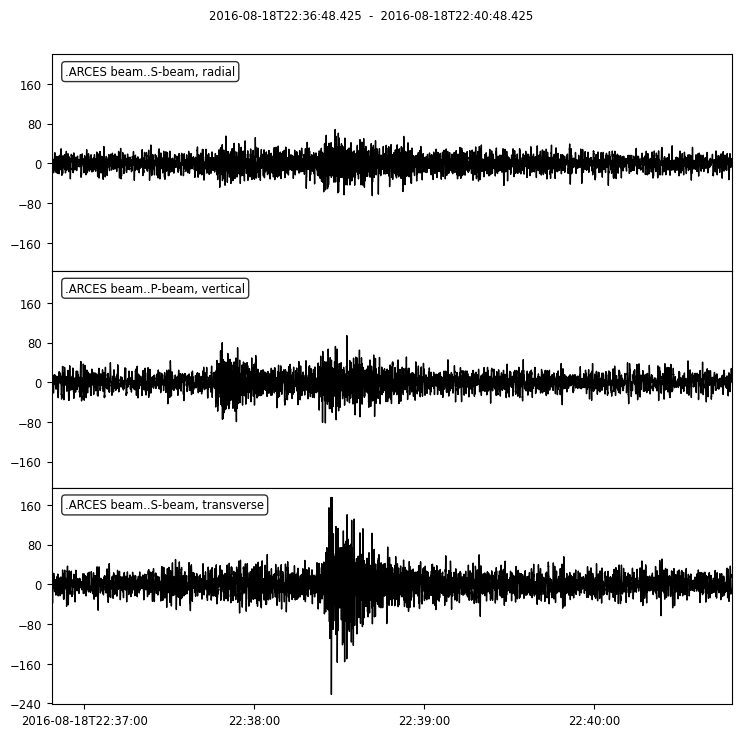

{   'analyst_pick_time': None,
    'az_to_arces': 35.204342682836355,
    'baz_to_arces': 219.7258470903545,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/d380fb6a-ed3c-4630-9832-e7f1cbaa89cd',
                        'text': 'FULLY AUTOMATIC, EVENT TYPE & LOCATION & '
                                'MAGNITUDE CHECKED (PIS)'},
                    {   'creation_info': {'author': 'mining area'},
                        'resource_id': 'smi:local/11ca96f5-c095-4f9e-bef3-bf6c552d0737',
                        'text': 'MINING AREA & TIME WINDOW: MALMBERGET  1KM'},
                    {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/1c73e8c6-8a34-4e90-9424-991b44364fad',
                        'text': 'SWEDEN'}],
    'dist_to_arces': 329.11444065695605,
    'est_arrivaltime_arces': '2016-08-18 22:37:48.432000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
 

In [109]:
# Plotting false negative
index = false_negatives_indexes[m]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
m += 1